# Employee Performance and Retention Analysis

In [1]:
!pip install tensorflow

In [2]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score,
                             f1_score, mean_squared_error, r2_score)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

**Phase‑1: Data Collection & Preprocessing**

In [3]:
# Loading dataset
df = pd.read_csv('employee_data.csv')
df

,EmployeeID,Name,Age,Department,Salary,YearsAtCompany,PerformanceScore,Attrition
0,1,John Doe,29,Sales,55000,3,80,No
1,2,Jane Smith,35,HR,60000,7,85,No
2,3,Michael Brown,40,Engineering,80000,10,95,Yes
3,4,Emily Davis,28,Marketing,65000,5,78,No
4,5,David Johnson,50,Sales,75000,20,88,Yes
...,...,...,...,...,...,...,...,...
95,96,Daniel Allen,29,HR,53000,3,79,No
96,97,Thomas Harris,40,Engineering,91000,13,92,Yes
97,98,Michael Lewis,45,Sales,75000,16,89,No
98,99,Linda Young,50,HR,70000,21,87,Yes


In [4]:
#check duplicate Employee ID
duplicates_in_ID = df['EmployeeID'].duplicated().sum()
print(duplicates_in_ID)

0


In [5]:
# 3. Quick data overview
print('\nData types and non‑null counts:')
print(df.info())


Data types and non‑null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   EmployeeID        100 non-null    int64 
 1   Name              100 non-null    object
 2   Age               100 non-null    int64 
 3   Department        100 non-null    object
 4   Salary            100 non-null    int64 
 5   YearsAtCompany    100 non-null    int64 
 6   PerformanceScore  100 non-null    int64 
 7   Attrition         100 non-null    object
dtypes: int64(5), object(3)
memory usage: 6.4+ KB
None


In [6]:
#Descriptive statistics:
print('\nDescriptive statistics:')
df.describe()[['Age', 'Salary', 'YearsAtCompany', 'PerformanceScore']]


Descriptive statistics:


,Age,Salary,YearsAtCompany,PerformanceScore
count,100.000000,100.000000,100.000000,100.000000
mean,36.570000,72820.000000,10.800000,84.940000
std,8.318478,12643.823102,6.361183,6.349771
min,25.000000,43000.000000,1.000000,70.000000
25%,29.750000,65000.000000,5.000000,80.000000
50%,35.000000,72000.000000,10.000000,85.500000
75%,41.250000,82750.000000,16.000000,90.000000
max,60.000000,95000.000000,25.000000,95.000000


**Phase‑1: Exploratory Data Analysis (EDA)**

Text(0.5, 1.02, 'Pairplot of Employee Features')

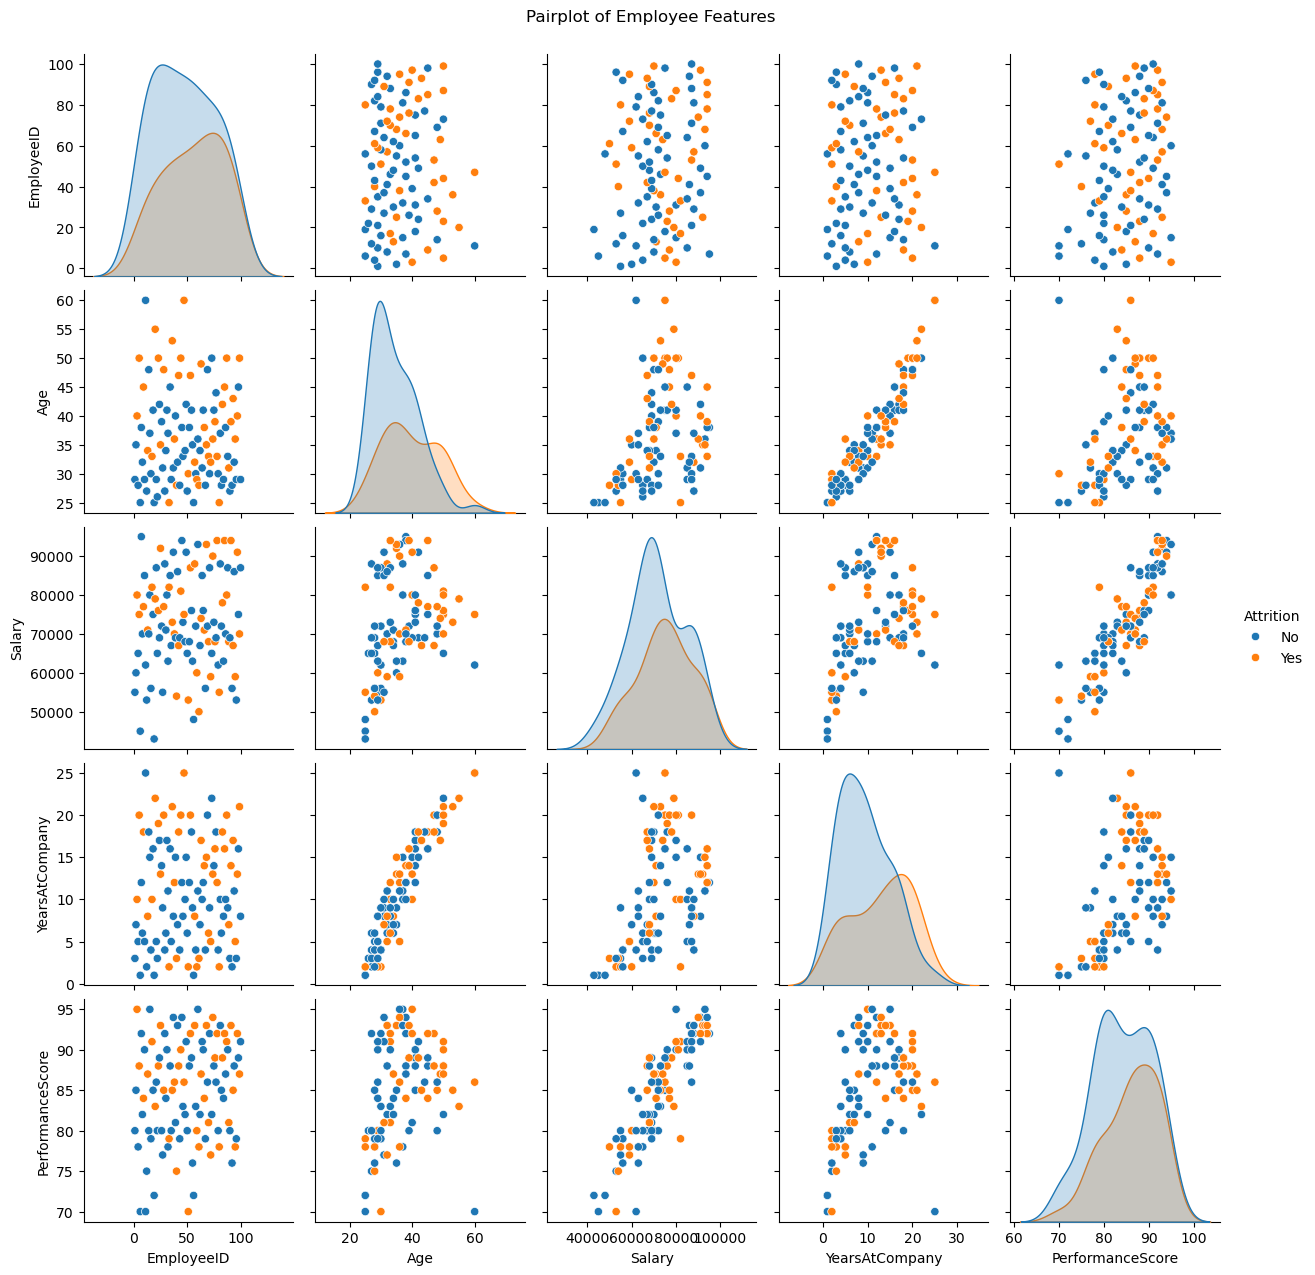

In [7]:
# 4. Pairplot
sns.pairplot(df, hue='Attrition')
plt.suptitle('Pairplot of Employee Features', y=1.02)

In [8]:
# correlation of column features
corr = df.corr(numeric_only=True)
corr

,EmployeeID,Age,Salary,YearsAtCompany,PerformanceScore
EmployeeID,1.000000,-0.023041,0.100207,0.021620,0.151666
Age,-0.023041,1.000000,0.281416,0.946127,0.305288
Salary,0.100207,0.281416,1.000000,0.413361,0.874773
YearsAtCompany,0.021620,0.946127,0.413361,1.000000,0.443331
PerformanceScore,0.151666,0.305288,0.874773,0.443331,1.000000


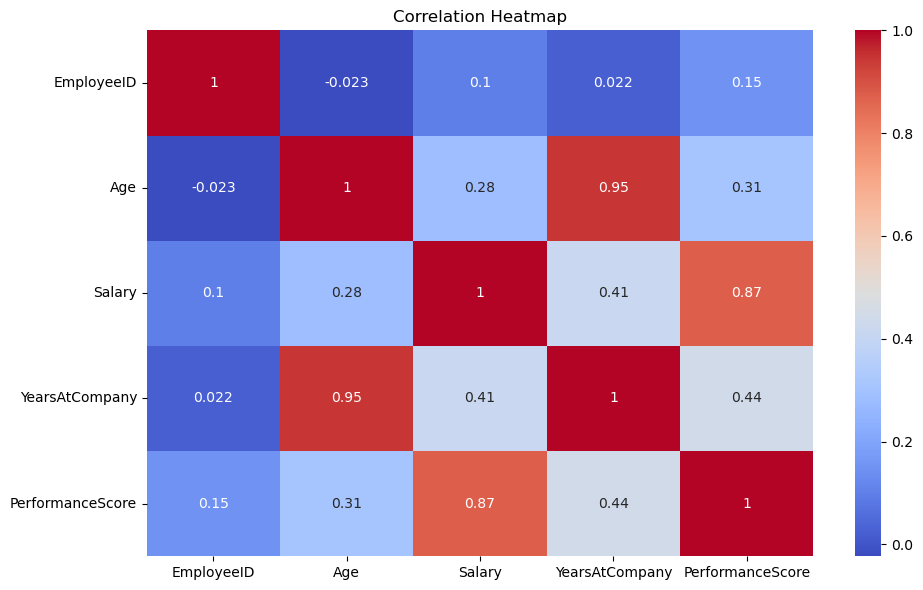

In [9]:
# 5. Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()

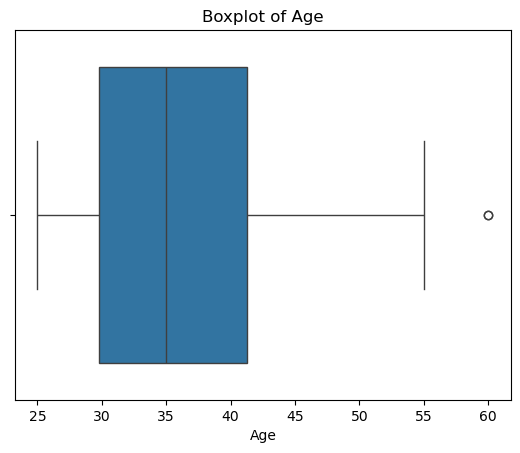

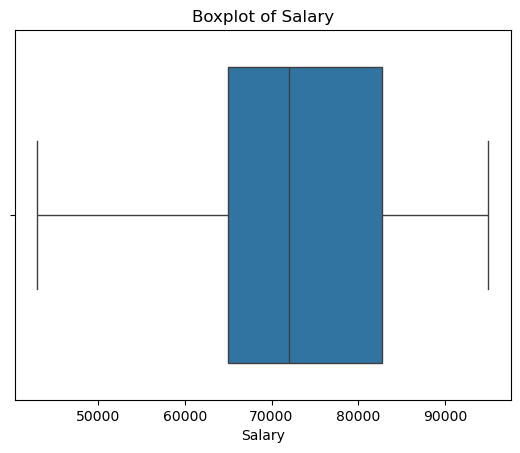

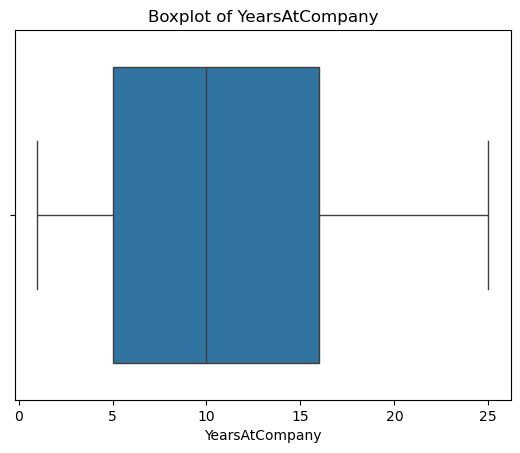

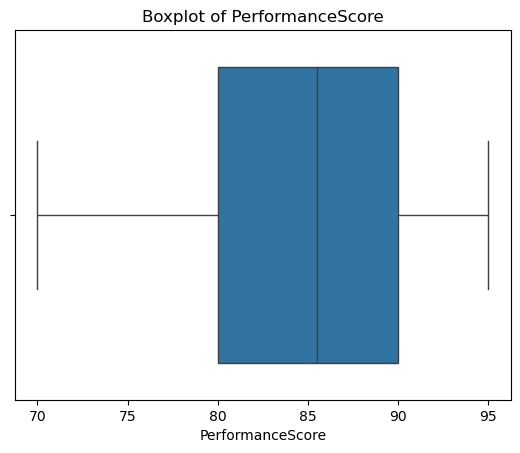

In [10]:
# 6. Boxplots to detect outliers
numeric_cols = ['Age', 'Salary', 'YearsAtCompany', 'PerformanceScore']
for col in numeric_cols:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')

**Phase‑1: Probability & Statistical Analysis**

In [11]:
# Probability & Statistical Analysis

attrition_prob = df.groupby('Department')['Attrition'].value_counts(normalize=True).unstack()
print('\nProbability of Attrition by Department:')
print(attrition_prob)


Probability of Attrition by Department:
Attrition          No       Yes
Department                     
Engineering  0.571429  0.428571
HR           0.653846  0.346154
Marketing    0.800000  0.200000
Sales        0.461538  0.538462


In [12]:
# Bayes: P(Attrition | Low Performance)

median_perf = df['PerformanceScore'].median()
low_perf = df[df['PerformanceScore'] < median_perf]
prob_attrition_given_low_perf = len(low_perf[low_perf['Attrition'] == 'Yes']) / len(low_perf)
print(f'\nP(Attrition | Low Performance) = {prob_attrition_given_low_perf:.3f}')


P(Attrition | Low Performance) = 0.320


In [13]:
# ANOVA: Performance score across departments- Hypothesis testing
groups = [grp['PerformanceScore'].values for _, grp in df.groupby('Department')]
anova_p = f_oneway(*groups).pvalue
print(f'ANOVA p‑value for PerformanceScore across Departments: {anova_p}')

ANOVA p‑value for PerformanceScore across Departments: 2.5591493445552222e-12


# Phase‑2: Feature Engineering

In [14]:
# Phase‑2: Feature Engineering & Encoding

# Encode categorical variables
le_attr = LabelEncoder()
df['AttritionEnc'] = le_attr.fit_transform(df['Attrition'])
le_dept = LabelEncoder()
df['DepartmentEnc'] = le_dept.fit_transform(df['Department'])
df

,EmployeeID,Name,Age,Department,Salary,YearsAtCompany,PerformanceScore,Attrition,AttritionEnc,DepartmentEnc
0,1,John Doe,29,Sales,55000,3,80,No,0,3
1,2,Jane Smith,35,HR,60000,7,85,No,0,1
2,3,Michael Brown,40,Engineering,80000,10,95,Yes,1,0
3,4,Emily Davis,28,Marketing,65000,5,78,No,0,2
4,5,David Johnson,50,Sales,75000,20,88,Yes,1,3
...,...,...,...,...,...,...,...,...,...,...
95,96,Daniel Allen,29,HR,53000,3,79,No,0,1
96,97,Thomas Harris,40,Engineering,91000,13,92,Yes,1,0
97,98,Michael Lewis,45,Sales,75000,16,89,No,0,3
98,99,Linda Young,50,HR,70000,21,87,Yes,1,1


In [15]:
# Scale numeric columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [16]:
# Machine‑Learning Models

# 1. Attrition Classification
X_cls = df[['Age', 'DepartmentEnc', 'Salary', 'YearsAtCompany', 'PerformanceScore']]
y_cls = df['AttritionEnc']
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls)

rf_cls = RandomForestClassifier(random_state=42)
rf_cls.fit(X_train_c, y_train_c)
y_pred_c = rf_cls.predict(X_test_c)

print('\nRandom Forest Classification Report:')
print(classification_report(y_test_c, y_pred_c))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.67      0.50      0.57         8

    accuracy                           0.70        20
   macro avg       0.69      0.67      0.67        20
weighted avg       0.70      0.70      0.69        20



Text(50.722222222222214, 0.5, 'Actual')

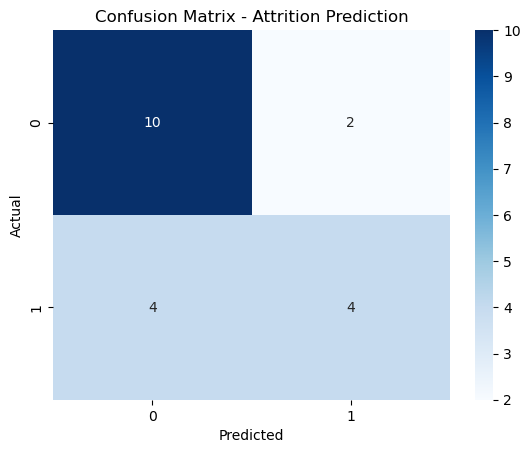

In [17]:
# confusion matrix
cm = confusion_matrix(y_test_c, y_pred_c)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Attrition Prediction')
plt.xlabel('Predicted'); plt.ylabel('Actual')

In [18]:
# 2. Performance Regression

X_reg = df[['Age', 'DepartmentEnc', 'Salary', 'YearsAtCompany']]
y_reg = df['PerformanceScore']
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train_r, y_train_r)
y_pred_r = lr.predict(X_test_r)

r2 = r2_score(y_test_r, y_pred_r)
mse = mean_squared_error(y_test_r, y_pred_r)
print(f'\nLinear Regression → R²: {r2:.3f}, MSE: {mse:.3f}')


Linear Regression → R²: 0.751, MSE: 0.318


Text(0.5, 1.0, 'Actual vs Predicted Performance (Linear Regression)')

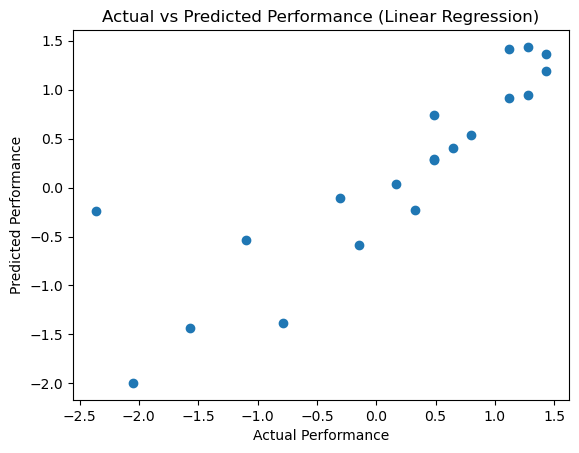

In [19]:
plt.scatter(y_test_r, y_pred_r)
plt.xlabel('Actual Performance'); plt.ylabel('Predicted Performance')
plt.title('Actual vs Predicted Performance (Linear Regression)')

# Phase‑3: Deep‑Learning Models

In [20]:
# Helper: build and compile a simple dense network

def build_regression_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_classification_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [21]:
# DL Regression

model_reg_dl = build_regression_model(X_train_r.shape[1])
model_reg_dl.fit(X_train_r, y_train_r, epochs=100, batch_size=8, verbose=0, validation_split=0.2)
dl_mse = model_reg_dl.evaluate(X_test_r, y_test_r, verbose=0)
print(f'Deep Learning Regression MSE: {dl_mse:.3f}')

C:\Users\bmoha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep Learning Regression MSE: 0.371


In [22]:
# DL Classification
model_cls_dl = build_classification_model(X_train_c.shape[1])
model_cls_dl.fit(X_train_c, y_train_c, epochs=100, batch_size=8, verbose=0, validation_split=0.2)
dl_loss, dl_acc = model_cls_dl.evaluate(X_test_c, y_test_c, verbose=0)
print(f'Deep Learning Classification Accuracy: {dl_acc:.3f}')

C:\Users\bmoha\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Deep Learning Classification Accuracy: 0.700


In [23]:
# Step 1: Get model predictions (probabilities)
y_pred_prob = model_cls_dl.predict(X_test_c)

# Step 2: Convert probabilities to binary class labels (0 or 1)
y_pred = (y_pred_prob > 0.5).astype("int32")  # threshold = 0.5

# Step 3: Classification Report (includes precision, recall, F1-score)
print(classification_report(y_test_c, y_pred))

precision = precision_score(y_test_c, y_pred)
recall = recall_score(y_test_c, y_pred)
f1 = f1_score(y_test_c, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
              precision    recall  f1-score   support

           0       0.71      0.83      0.77        12
           1       0.67      0.50      0.57         8

    accuracy                           0.70        20
   macro avg       0.69      0.67      0.67        20
weighted avg       0.70      0.70      0.69        20

Precision: 0.67
Recall: 0.50
F1-Score: 0.57



### Phase‑4: Insights & Recommendations ###
* Employees with low performance & long tenure show higher attrition risk.
* Sales and HR departments indicate comparatively higher attrition probabilities.
* Salary and years at company have moderate positive correlation with performance.


Text(0.5, 1.0, 'Department‑wise Attrition')

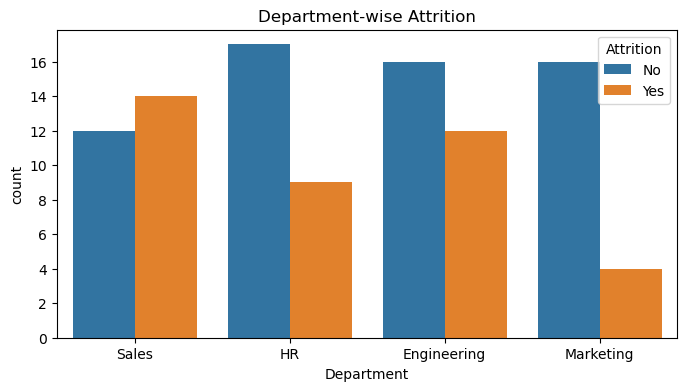

In [24]:
# Phase‑4: Insights & Visualisations

print('\n### Phase‑4: Insights & Recommendations ###')

# Key insights
print('* Employees with low performance & long tenure show higher attrition risk.')
print('* Sales and HR departments indicate comparatively higher attrition probabilities.')
print('* Salary and years at company have moderate positive correlation with performance.')

# Bar plot: Department‑wise attrition
plt.figure(figsize=(8,4))
sns.countplot(x='Department', hue='Attrition', data=df)
plt.title('Department‑wise Attrition')

Text(0.5, 1.0, 'Salary vs Performance Score')

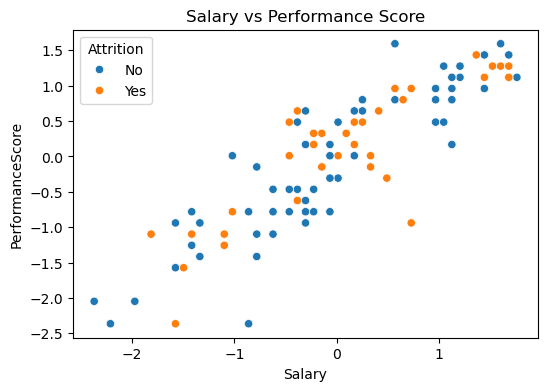

In [25]:
# Scatter: Salary vs Performance, colored by Attrition
plt.figure(figsize=(6,4))
sns.scatterplot(x='Salary', y='PerformanceScore', hue='Attrition', data=df)
plt.title('Salary vs Performance Score')